IDEAT: KMEANS VIX, Cap max weight for factor

<div style="font-size:14px;">
<strong>TO DO:</strong><br><br>
Tarkistaa ovatko regiimit oikein, exp. antaa ainoana kaikille neg sharpet<br>
Katsoa vielä financial turbulence koodi<br>
Data varmistukset (ei dataa tulevaisuudesta)<br><br>

<strong>Lisää features:</strong><br>
RSI<br>
Yield spread<br>
Muita??<br><br>

<strong>Muuta:</strong><br>
regiimi testaus drawdowneilla?<br><br>
regiimi specifi model ennustus?


<strong>Mallin kehitys:</strong><br>
1. Feature eliminointi<br>
2. Training interval<br>
3. Hyperparametrit
</div>



# GIT & imports

In [772]:
# # GitHub Repository Setup
#
# This cell navigates to `/content`, removes any previous clone of the repository,
# clones the latest version from GitHub, and lists the repository files.

# %%
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls


/content
Cloning into 'Gradu'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 572 (delta 144), reused 124 (delta 124), pack-reused 420 (from 2)
Receiving objects: 100% (572/572), 113.19 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (268/268), done.
/content/Gradu
 chatti_RF.ipynb		      regime_prediction_msci.ipynb
 data+regimes.xlsx		      regime_pred.txt
 Fama_french_XGBOOST.ipynb	      RF_Gradu.ipynb
'Financial turbulence.ipynb'	     'RF REGIIMI HYVÄ TRAINING.ipynb'
 FT_source.xlsx			     'RF_REGIIMI_HYVÄ_TRAINING (MSCI).ipynb'
 Gradient_boost_malli.ipynb	     'RF_regime (3).ipynb'
 MSCI_XGBOOST.ipynb		      THE_2ND_latest.xlsx
 Regiimi_prediction.ipynb	      THE_2ND.xlsx
 regime_prediction_famafrench.ipynb   THE_ONE.xlsx


In [773]:
use_regime_split = False

RF = False # perus random forest
GB = False # perus gradient boost
RF_feature_seek = False # random forest all combinations / not updated
Hybrid = True


FF5 = False
FF5_long = False
MSCI = True


In [774]:
if sum([RF, GB, RF_feature_seek, Hybrid]) != 1:
    raise ValueError("Error: Exactly one of [RF, GB, RF_feature_seek, Hybrid] must be True.")

# Check subgroup 2: Exactly one of [FF5, FF5_long, MSCI] must be True
if sum([FF5, FF5_long, MSCI]) != 1:
    raise ValueError("Error: Exactly one of [FF5, FF5_long, MSCI] must be True.")

print("Toggles are correctly set.")


Toggles are correctly set.


In [775]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [776]:
if FF5:
  SHEET_NAME = "ajodata_FF5"
  FEATURES = ['CPI%', 'GARCH_1M', 'T10YFF', 'LEI%', 'Amihud']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = False

In [777]:
if FF5_long:
  SHEET_NAME = "ajodata_FF5_long"
  FEATURES = ['CPI%', 'GARCH_1M', 'T10YFF', 'LEI%', 'Amihud']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = True

In [778]:
if MSCI:
  SHEET_NAME = "ajodata_MSCI"
  FEATURES = ['CPI%', 'GARCH_1M', 'T10YFF', 'LEI%', 'Amihud']
  FACTORS = [
    'Size',
    'value',
    'Quality',
    'min_vola']
  BENCHMARK = ['Us_standard']
  show_benchmark = True

In [779]:
xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")
df = xls_file.parse(SHEET_NAME)

df.columns = df.columns.get_level_values(0)

# Print headers dynamically
print(f"Headers in the '{SHEET_NAME}' sheet:")
print(df.columns)

REGIMES_COLUMN = 'Predicted_reg'

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'ajodata_MSCI' sheet:
Index(['Date', 'Us_standard', 'Size', 'Momentum', 'min_vola', 'value',
       'Quality', 'GARCH_1M', 'CPI%', 'T10YFF', 'T10YFF_CHG', 'Amihud',
       'LEI%'],
      dtype='object')


Description,Value
First observation date,1979-12-30 00:00:00
Last observation date,2024-11-30 00:00:00
Total number of observations,540


In [780]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,9.35%,15.20%,5492.47%
Size,9.60%,14.27%,6085.82%
value,9.14%,15.39%,5012.40%
Quality,11.35%,15.12%,12519.41%
min_vola,6.64%,11.72%,1706.35%


In [781]:
# # Prepare Data for Model Training – Data Cleaning & Verification

# we keep all rows and compute the winning factor as the factor (from FACTORS) with the highest value in each row.

# Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# Check missing values in feature columns (FEATURES) before dropping NAs.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in feature columns before dropping NA:")
print(missing_counts)

# Save the number of rows before dropping NA and then drop rows with missing values in FEATURES.
initial_rows_features = len(df)
X = df[FEATURES].dropna()
rows_after_drop = len(X)
dropped_rows = initial_rows_features - rows_after_drop

if dropped_rows > 0:
    print(f"\nDropped {dropped_rows} rows due to missing values in feature columns.")
else:
    print("\nNo missing values found in feature columns. Data is clean.")

# Compute the Winning Factor by taking the column (from FACTORS) that has the maximum value in each row.
# This assumes that the FACTORS columns exist in df and contain numeric values.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1)

# Define the target variable based on rows retained in X.
# The winning factor is encoded as a categorical variable.
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]
print("\nIndices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date.
df = df.sort_values('Date').reset_index(drop=True)

# Verify that all required columns exist.
# Here, we require the FEATURES columns, the 'USA Standard (Large+Mid Cap)' column,
# as well as all the FACTORS and the BENCHMARK columns.
required_columns = FEATURES + FACTORS + BENCHMARK
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("\nParameters and dataset verified.")

# Compute the counts for each winning factor.
winning_factor_counts = df['Winning Factor'].value_counts()

# Compute total count and append it as the last row.
total_counts = winning_factor_counts.sum()
winning_factor_counts = pd.concat([winning_factor_counts, pd.Series({'Total': total_counts})])

# Print the counts with "Total" as the last row.
print("\nWinning Factor counts:")
print(winning_factor_counts)




Total number of rows before cleaning: 540

Missing values in feature columns before dropping NA:
CPI%        0
GARCH_1M    0
T10YFF      0
LEI%        0
Amihud      0
dtype: int64

No missing values found in feature columns. Data is clean.

Indices aligned: True

Parameters and dataset verified.

Winning Factor counts:
Quality     193
Size        126
value       116
min_vola    105
Total       540
dtype: int64


In [782]:
if use_regime_split:

    # --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

    # Dynamically extract the unique values in the REGIMES_COLUMN.
    unique_regimes = df[REGIMES_COLUMN].unique()

    # Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
    df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

    # Create a dictionary mapping numeric codes to the regime names based on the unique values.
    regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

    # Now encode the Regimes column as numeric codes.
    df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

    # Create a mapping from numeric codes to original regime names.
    regime_short_mapping = {code: name for code, name in regime_mapping.items()}

    # Calculate the number of observations for each regime using value_counts (without reindexing).
    obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

    # Create a DataFrame preview of the regime mapping, including observation counts.
    mapping_table_data = []
    for code in regime_mapping.keys():
        mapping_table_data.append({
            "Numeric Code": code,
            "Original Name": regime_mapping.get(code, "N/A"),
            "Observations": obs_counts.get(code, 0)
        })

    # Append a row with the total observations.
    total_obs = obs_counts.sum()
    mapping_table_data.append({
        "Numeric Code": "",
        "Original Name": "Total",
        "Observations": total_obs
    })

    # Create the DataFrame for regime mapping preview and print.
    regime_mapping_df = pd.DataFrame(mapping_table_data)

    from tabulate import tabulate
    print("Preview of Dynamic Regime Mapping:")
    print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


# Training

### Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [783]:
# This removes any row with at least one NaN in any column
df = df.dropna()

# Optionally, reindex the rows
df.reset_index(drop=True, inplace=True)

In [784]:
df

,Date,Us_standard,Size,Momentum,min_vola,value,Quality,GARCH_1M,CPI%,T10YFF,T10YFF_CHG,Amihud,LEI%,Winning Factor
0,1988-06-30,0.043323,0.043799,0.033579,0.032225,0.047154,0.037395,0.802078,0.42553,1.28,-0.17,1.312876e-13,0.003407,value
1,1988-07-30,-0.006198,-0.012095,-0.012041,-0.007055,-0.004743,0.001711,1.471245,0.42373,1.11,-0.78,9.325133e-15,0.006791,Quality
2,1988-08-30,-0.036689,-0.026526,-0.047391,-0.023115,-0.036281,-0.026872,0.703486,0.42194,0.33,-0.07,6.857909e-14,0.000000,min_vola
3,1988-09-30,0.039493,0.038130,0.041126,0.054148,0.037351,0.051736,0.408904,0.42017,0.26,0.30,4.239543e-14,0.003373,min_vola
4,1988-10-30,0.027519,0.014227,0.017219,0.018087,0.027552,0.021731,0.733629,0.33473,0.56,-0.46,6.126809e-14,0.003361,value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2024-07-30,0.011716,0.047299,-0.021593,0.036042,0.034542,0.002305,1.087011,0.13892,-1.42,0.40,0.000000e+00,-0.001940,Size
434,2024-08-30,0.022720,0.031729,0.028126,0.047736,0.015412,0.034802,0.641443,0.18019,-1.02,0.47,0.000000e+00,-0.004859,min_vola
435,2024-09-30,0.020355,0.016242,0.030033,0.003052,0.010191,0.008523,0.396629,0.22920,-0.55,0.15,0.000000e+00,-0.002930,Size
436,2024-10-30,-0.008114,-0.015492,-0.003074,-0.015629,-0.009584,-0.018075,0.684819,0.22646,-0.40,0.65,0.000000e+00,-0.003918,value


In [785]:
if RF_feature_seek:
  import itertools
  import os
  import pandas as pd
  import numpy as np
  import time  # Added for timing
  from sklearn.ensemble import RandomForestClassifier

  # --- PARAMETERS ---
  overall_window_size = 120    # Training observations to use
  min_obs_train = 0            # Global minimum observations to start predictions
  min_obs_regime = 50          # Minimum observations required FOR EACH REGIME

  # Assume these are defined in your notebook:
  #   - df: your DataFrame with a Date column and other features.
  #   - FEATURES: your full list of features (e.g., ['NFCI', 'T10YFF', 'DGS1', 'DGS5', 'CPI', 'Cape', 'Treasury_10Y'])
  #   - REGIMES_COLUMN: the column name for regimes.
  #   - regime_short_mapping: a dictionary mapping regime codes to names.
  #   - FACTORS: list of factor names used for return allocation.
  #   - use_regime_split: Boolean flag whether to use regime splitting.

  # For testing, we'll use the full FEATURES list for sub-sampling.
  features_to_test = FEATURES  # e.g., ['NFCI', 'T10YFF', 'DGS1', 'DGS5', 'CPI', 'Cape', 'Treasury_10Y']

  # Generate all combinations of features (subsets of size 3 up to len(features_to_test))
  all_feature_combinations = []
  for r in range(3, len(features_to_test) + 1):
      all_feature_combinations.extend(list(itertools.combinations(features_to_test, r)))

  # Setup output file.
  output_filename = "feature_subset_results.csv"
  # Remove the file if it exists to start fresh.
  if os.path.exists(output_filename):
      os.remove(output_filename)

  # Ensure the data is sorted by date.
  df_sorted = df.sort_values('Date').reset_index(drop=True)

  # Outer loop: iterate over each feature combination.
  for comb in all_feature_combinations:
      current_features = list(comb)
      start_time = time.time()  # Start timer for this combination
      print(f"\nTesting feature combination: {current_features}")

      # Container for results for this specific feature subset.
      results = []

      # Rolling window loop: iterate over each test row.
      for i in range(overall_window_size, len(df_sorted)):
          test_row = df_sorted.iloc[i]
          Predicted_month = test_row['Date']

          # If regime splitting is active, check that all regimes have enough observations.
          if use_regime_split:
              data_up_to_now = df_sorted.iloc[:i]
              regime_counts = data_up_to_now[REGIMES_COLUMN].value_counts()
              insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
              if insufficient_regimes:
                  continue

          # Build the training window.
          if use_regime_split:
              current_regime = test_row[REGIMES_COLUMN]
              train_rows = []
              j = i - 1
              while j >= 0 and len(train_rows) < overall_window_size:
                  candidate = df_sorted.iloc[j]
                  if candidate[REGIMES_COLUMN] == current_regime:
                      train_rows.append(candidate)
                  j -= 1
              if len(train_rows) < min_obs_regime:
                  continue
              train_window = pd.DataFrame(train_rows[::-1])
          else:
              train_window = df_sorted.iloc[i - overall_window_size: i].copy()
              if len(train_window) < min_obs_train:
                  continue

          # Ensure the last training observation is from a strictly earlier month.
          last_train_date = train_window['Date'].iloc[-1]
          if last_train_date.year == Predicted_month.year and last_train_date.month >= Predicted_month.month:
              continue

          # Prepare training data using the current feature subset.
          X_train = train_window[current_features].dropna()
          y_train = train_window['Winning Factor'].loc[X_train.index]
          if len(X_train) < min_obs_train:
              continue

          # Train the Random Forest model.
          rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
          rf_model.fit(X_train, y_train)

          # Compute tree depth statistics (for logging).
          tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
          avg_depth = np.mean(tree_depths)
          max_depth = np.max(tree_depths)

          # Prepare test data using the same feature subset.
          X_test = test_row[current_features].to_frame().T.dropna()
          if X_test.empty:
              continue

          # Predict probabilities and winning factor.
          predicted_probabilities = rf_model.predict_proba(X_test)[0]
          predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

          # Allocate return by weighting each factor's return by its predicted probability.
          full_probs = np.zeros(len(FACTORS))
          for cls, prob in zip(rf_model.classes_, predicted_probabilities):
              try:
                  idx = FACTORS.index(cls)
                  full_probs[idx] = prob
              except ValueError:
                  print(f"Warning: Class '{cls}' not found in FACTORS.")
          allocated_return = (full_probs * test_row[FACTORS].values).sum()

          # Determine the regime used (if applicable).
          if use_regime_split:
              regime_used = regime_short_mapping.get(test_row[REGIMES_COLUMN], str(test_row[REGIMES_COLUMN]))
          else:
              regime_used = 'NoRegime'

          # Compute the average feature importance for this model.
          avg_feature_importance = np.mean(rf_model.feature_importances_)

          # Store the result for this test row.
          result = {
              'Features_used': str(current_features),
              'Regime': regime_used,
              'Predicted_month': Predicted_month,
              'Allocated_Return': allocated_return,
              'Feature_Importances': rf_model.feature_importances_,
              'Average_Feature_Importance': avg_feature_importance,
              'Predicted_Winner': predicted_winner,
              'Actual_Winner': test_row['Winning Factor'],
              'Num_Trees': rf_model.n_estimators,
              'Average_Tree_Depth': avg_depth,
              'Max_Tree_Depth': max_depth
          }
          results.append(result)

      # If there are any results for this feature combination, save them to CSV.
      if results:
          df_results_comb = pd.DataFrame(results)
          # Append to CSV; if the file doesn't exist, include the header.
          if not os.path.exists(output_filename):
              df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
          else:
              df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
          elapsed_time = time.time() - start_time  # Calculate elapsed time
          minutes = int(elapsed_time // 60)
          seconds = int(elapsed_time % 60)
          print(f"Results for combination {current_features} appended to CSV. Time taken: {minutes:02d}:{seconds:02d}")

## Random forest

In [786]:
if RF or Hybrid:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from IPython.display import display, HTML

    # -------------------
    # 1) Parameters
    # -------------------
    min_years_train = 5      # Min years of data needed
    min_obs_regime = 50      # Min obs per regime if splitting
    min_obs_train = 0        # Min total obs after dropping NAs
    use_regime_split = False # Toggle regime-based training or not

    # New toggle for training window type:
    use_fixed_window = False  # Set to True for fixed (rolling) window, False for expanding window
    rolling_window_size = 120  # When using a fixed window, use this many most recent rows

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window: either a fixed-size (rolling) window or an expanding window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check training years
        training_years = (Predicted_month - train_window['Date'].iloc[0]).days / 365.25
        if training_years < min_years_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training period ({training_years:.2f} years). Skipping.")
            continue

        # Get first and last date in training window
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks
        if use_regime_split:
            # Check each regime has enough data
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                regime_str = ", ".join(regime_str_list)
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active. Insufficient data in: {regime_str}. Skipping.\n")
                continue

            # Use only training data for the current regime
            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.\n")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Check last training date < test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.\n")
            continue

        # Prepare X_train / y_train
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.\n")
            continue

        # Fit RandomForest
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Predict using the last row in training window (previous month’s features)
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.\n")
            continue

        predicted_probabilities = rf_model.predict_proba(X_test)[0]
        predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

        # Map probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for cls, prob in zip(rf_model.classes_, predicted_probabilities):
            try:
                idx = FACTORS.index(cls)
                full_probs[idx] = prob
            except ValueError:
                pass  # or print a warning

        # Use the test_row's factor returns to compute the allocated return
        allocated_return = (full_probs * test_row[FACTORS].values).sum()

        # Gather results
        tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
        avg_depth = np.mean(tree_depths)
        max_depth = np.max(tree_depths)

        # Calculate how many months ahead the prediction is
        months_ahead = (
            (Predicted_month.year - last_train_date.year) * 12 +
            (Predicted_month.month - last_train_date.month)
        )

        # Store the actual feature levels used in X_test
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        # Print the training window used for this test row
        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        # Build the result row
        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': rf_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build the final results DataFrame for RF
    # -------------------
    results_df_rf = pd.DataFrame(results)
    print("Final results_df_rf columns:", results_df_rf.columns.tolist())

    # Show the last few rows
    display(results_df_rf.tail(10))


Test row date: 1988-07-30 - Insufficient training period (0.08 years). Skipping.
Test row date: 1988-08-30 - Insufficient training period (0.17 years). Skipping.
Test row date: 1988-09-30 - Insufficient training period (0.25 years). Skipping.
Test row date: 1988-10-30 - Insufficient training period (0.33 years). Skipping.
Test row date: 1988-11-30 - Insufficient training period (0.42 years). Skipping.
Test row date: 1988-12-30 - Insufficient training period (0.50 years). Skipping.
Test row date: 1989-01-30 - Insufficient training period (0.59 years). Skipping.
Test row date: 1989-02-28 - Insufficient training period (0.67 years). Skipping.
Test row date: 1989-03-30 - Insufficient training period (0.75 years). Skipping.
Test row date: 1989-04-30 - Insufficient training period (0.83 years). Skipping.
Test row date: 1989-05-30 - Insufficient training period (0.91 years). Skipping.
Test row date: 1989-06-30 - Insufficient training period (1.00 years). Skipping.
Test row date: 1989-07-30 - 

,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud
367,NoRegime,2024-02-29,1988-06-30,2024-01-30,428,"[0.19804483310465523, 0.21534547266345705, 0.1...","[0.07, 0.05, 0.83, 0.05]",Quality,0.061615,Quality,100,16.68,22,1,0.34301,0.726558,-1.08,-0.000954,0.0
368,NoRegime,2024-03-30,1988-06-30,2024-02-29,429,"[0.19771485369384184, 0.20911333654877828, 0.2...","[0.06, 0.03, 0.78, 0.13]",Quality,0.025407,value,100,16.82,21,1,0.39639,0.780011,-1.13,-0.004776,0.0
369,NoRegime,2024-04-30,1988-06-30,2024-03-30,430,"[0.20436550637539663, 0.21059318547795652, 0.1...","[0.0, 0.69, 0.31, 0.0]",value,-0.043801,min_vola,100,16.56,23,1,0.34885,0.496170,-0.64,0.000960,0.0
370,NoRegime,2024-05-30,1988-06-30,2024-04-30,431,"[0.20246675109042256, 0.21526641895558105, 0.1...","[0.04, 0.03, 0.28, 0.65]",min_vola,0.034993,Quality,100,16.75,23,1,0.29125,0.944764,-0.82,-0.001918,0.0
371,NoRegime,2024-06-30,1988-06-30,2024-05-30,432,"[0.2011159788483306, 0.21441487001066298, 0.19...","[0.08, 0.18, 0.67, 0.07]",Quality,0.028441,Quality,100,16.59,22,1,0.03961,0.569002,-0.97,-0.005764,0.0
372,NoRegime,2024-07-30,1988-06-30,2024-06-30,433,"[0.19186195769466777, 0.21167624843011185, 0.2...","[0.05, 0.1, 0.76, 0.09]",Quality,0.010815,Size,100,16.76,22,1,-0.00287,0.327046,-1.24,-0.003865,0.0
373,NoRegime,2024-08-30,1988-06-30,2024-07-30,434,"[0.19567518717636062, 0.21158479330182686, 0.2...","[0.75, 0.03, 0.15, 0.07]",Size,0.032821,min_vola,100,16.84,22,1,0.13892,1.087011,-1.42,-0.001940,0.0
374,NoRegime,2024-09-30,1988-06-30,2024-08-30,435,"[0.19929697896703236, 0.21464314887790625, 0.1...","[0.07, 0.18, 0.17, 0.58]",min_vola,0.006190,Size,100,16.64,22,1,0.18019,0.641443,-1.02,-0.004859,0.0
375,NoRegime,2024-10-30,1988-06-30,2024-09-30,436,"[0.20154298851964622, 0.214447626010717, 0.203...","[0.62, 0.14, 0.22, 0.02]",Size,-0.015236,value,100,16.54,23,1,0.22920,0.396629,-0.55,-0.002930,0.0
376,NoRegime,2024-11-30,1988-06-30,2024-10-30,437,"[0.19650214253825374, 0.22205637845376658, 0.2...","[0.14, 0.7, 0.06, 0.1]",value,0.060832,value,100,16.64,22,1,0.22646,0.684819,-0.40,-0.003918,0.0


## Gradient boosting


In [787]:
if GB or Hybrid:
    import pandas as pd
    import numpy as np
    from xgboost import XGBClassifier
    from IPython.display import display, HTML

    # -------------------
    # 1) Parameters
    # -------------------
    min_years_train = 5      # Minimum years of data needed
    min_obs_regime = 50      # Minimum observations per regime (if using regime split)
    min_obs_train = 0        # Minimum observations after dropping NAs
    use_regime_split = False # Toggle regime-based training or not

    # Toggle for training window type:
    use_fixed_window = True  # True for fixed (rolling) window; False for expanding window
    rolling_window_size = 120  # When using a fixed window, use this many most recent rows

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window: either fixed-size (rolling) or expanding window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check training years available
        training_years = (Predicted_month - train_window['Date'].iloc[0]).days / 365.25
        if training_years < min_years_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training period ({training_years:.2f} years). Skipping.")
            continue

        # Get first and last training dates
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks (if enabled)
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                regime_str = ", ".join(regime_str_list)
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active. Insufficient data in: {regime_str}. Skipping.")
                continue

            # Use only training data for the current regime
            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Ensure the last training date is strictly before the test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.")
            continue

        # Prepare training data
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.")
            continue

        # Convert y_train from strings to numeric codes and save mapping
        y_train_cat = y_train.astype('category')
        mapping = dict(enumerate(y_train_cat.cat.categories))
        y_train_numeric = y_train_cat.cat.codes

        # Fit XGBoost gradient boosting classifier on numeric labels (full training, no early stopping)
        xgb_model = XGBClassifier(n_estimators=100,
                                  random_state=42,
                                  eval_metric='mlogloss')
        xgb_model.fit(X_train, y_train_numeric)

        # Prepare test data (using the last row in the training window)
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.")
            continue

        predicted_probabilities = xgb_model.predict_proba(X_test)[0]
        # Get predicted numeric class and convert back to original factor name
        predicted_numeric = xgb_model.classes_[predicted_probabilities.argmax()]
        predicted_winner = mapping[predicted_numeric]

        # Map predicted probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for code, prob in zip(xgb_model.classes_, predicted_probabilities):
            factor_name = mapping[code]
            try:
                idx = FACTORS.index(factor_name)
                full_probs[idx] = prob
            except ValueError:
                pass  # Skip if factor not found in FACTORS

        # Compute allocated return using the test row's factor returns
        allocated_return = (full_probs * test_row[FACTORS].values).sum()

        # Tree depth statistics are not required, so we set them to None
        avg_depth = None
        max_depth = None

        # Calculate prediction horizon (months ahead)
        months_ahead = ((Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month))

        # Store the actual feature levels used in X_test
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        # Build the result dictionary for this iteration
        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': xgb_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': xgb_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build the final results DataFrame for GB
    # -------------------
    results_df_gb = pd.DataFrame(results)
    print("Final results_df_gb columns:", results_df_gb.columns.tolist())
    display(results_df_gb.tail(10))


Test row date: 1988-07-30 - Insufficient training period (0.08 years). Skipping.
Test row date: 1988-08-30 - Insufficient training period (0.17 years). Skipping.
Test row date: 1988-09-30 - Insufficient training period (0.25 years). Skipping.
Test row date: 1988-10-30 - Insufficient training period (0.33 years). Skipping.
Test row date: 1988-11-30 - Insufficient training period (0.42 years). Skipping.
Test row date: 1988-12-30 - Insufficient training period (0.50 years). Skipping.
Test row date: 1989-01-30 - Insufficient training period (0.59 years). Skipping.
Test row date: 1989-02-28 - Insufficient training period (0.67 years). Skipping.
Test row date: 1989-03-30 - Insufficient training period (0.75 years). Skipping.
Test row date: 1989-04-30 - Insufficient training period (0.83 years). Skipping.
Test row date: 1989-05-30 - Insufficient training period (0.91 years). Skipping.
Test row date: 1989-06-30 - Insufficient training period (1.00 years). Skipping.
Test row date: 1989-07-30 - 

,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud
367,NoRegime,2024-02-29,2014-02-28,2024-01-30,120,"[0.25727043, 0.21057826, 0.22374088, 0.1646177...","[0.00027840796974487603, 0.0004331277159508317...",Quality,0.068005,Quality,100,None,None,1,0.34301,0.726558,-1.08,-0.000954,0.0
368,NoRegime,2024-03-30,2014-03-30,2024-02-29,120,"[0.25718987, 0.21562387, 0.20004722, 0.1601477...","[0.00798756629228592, 0.004239293280988932, 0....",Quality,0.022980,value,100,None,None,1,0.39639,0.780011,-1.13,-0.004776,0.0
369,NoRegime,2024-04-30,2014-04-30,2024-03-30,120,"[0.239758, 0.23970431, 0.22677954, 0.17030513,...","[0.0020806919783353806, 0.9196926951408386, 0....",value,-0.043644,min_vola,100,None,None,1,0.34885,0.496170,-0.64,0.000960,0.0
370,NoRegime,2024-05-30,2014-05-30,2024-04-30,120,"[0.2416711, 0.24188347, 0.2078665, 0.16723232,...","[0.0018075535772368312, 0.0023707952350378036,...",min_vola,0.027858,Quality,100,None,None,1,0.29125,0.944764,-0.82,-0.001918,0.0
371,NoRegime,2024-06-30,2014-06-30,2024-05-30,120,"[0.2325252, 0.24679244, 0.18385087, 0.17271113...","[0.008511267602443695, 0.05029132217168808, 0....",Quality,0.037366,Quality,100,None,None,1,0.03961,0.569002,-0.97,-0.005764,0.0
372,NoRegime,2024-07-30,2014-07-30,2024-06-30,120,"[0.2165519, 0.24322008, 0.2035747, 0.17870478,...","[0.001150214928202331, 0.0031146507244557142, ...",Quality,0.002678,Size,100,None,None,1,-0.00287,0.327046,-1.24,-0.003865,0.0
373,NoRegime,2024-08-30,2014-08-30,2024-07-30,120,"[0.2063664, 0.24014315, 0.1913637, 0.18523325,...","[0.953673243522644, 0.00165492482483387, 0.025...",Size,0.032092,min_vola,100,None,None,1,0.13892,1.087011,-1.42,-0.001940,0.0
374,NoRegime,2024-09-30,2014-09-30,2024-08-30,120,"[0.23404981, 0.21617275, 0.21885413, 0.1691127...","[0.01910160295665264, 0.003235345706343651, 0....",min_vola,0.003536,Size,100,None,None,1,0.18019,0.641443,-1.02,-0.004859,0.0
375,NoRegime,2024-10-30,2014-10-30,2024-09-30,120,"[0.23675261, 0.25155407, 0.18938802, 0.1607615...","[0.9390862584114075, 0.018373051658272743, 0.0...",Size,-0.015457,value,100,None,None,1,0.22920,0.396629,-0.55,-0.002930,0.0
376,NoRegime,2024-11-30,2014-11-30,2024-10-30,120,"[0.2324777, 0.24573761, 0.197801, 0.15640125, ...","[0.01988028734922409, 0.9401943683624268, 0.01...",value,0.063407,value,100,None,None,1,0.22646,0.684819,-0.40,-0.003918,0.0


##Hybrid / tää säilyttää random forestin dataframen mut averagee painot ja laskee allocated returns nistä

In [792]:
if Hybrid:
    import numpy as np
    import pandas as pd

    # Ensure that RF and GB results exist before merging
    if 'results_df_rf' in locals() and 'results_df_gb' in locals():
        # Create temporary DataFrames containing only the predicted weights from RF and GB
        rf_subset = results_df_rf[['Predicted_month', 'Predicted_Probabilities']].copy()
        gb_subset = results_df_gb[['Predicted_month', 'Predicted_Probabilities']].copy()

        # Merge on Predicted_month
        hybrid_temp = pd.merge(
            rf_subset,
            gb_subset,
            on='Predicted_month',
            suffixes=('_rf', '_gb')
        )

        # Compute the average predicted probabilities (ensemble)
        hybrid_temp['Predicted_Probabilities'] = hybrid_temp.apply(
            lambda row: (np.array(row['Predicted_Probabilities_rf']) + np.array(row['Predicted_Probabilities_gb'])) / 2,
            axis=1
        )

        # Function to compute allocated return given a probability vector and factor returns
        def compute_allocated_return(prob_vector, factor_returns):
            return np.dot(prob_vector, factor_returns)

        # Compute the allocated return for each row using the hybrid weights
        hybrid_temp['Hybrid_Allocated_Return'] = hybrid_temp.apply(
            lambda row: compute_allocated_return(
                row['Predicted_Probabilities'],
                df.loc[df['Date'] == row['Predicted_month'], FACTORS].values.flatten()
            ) if not df.loc[df['Date'] == row['Predicted_month'], FACTORS].empty else np.nan,
            axis=1
        )

        # Now merge the new hybrid values back into the full RF results so we keep all the RF columns
        hybrid_df = results_df_rf.merge(
            hybrid_temp[['Predicted_month', 'Predicted_Probabilities', 'Hybrid_Allocated_Return']],
            on='Predicted_month',
            how='left'
        )

        # Override the RF predicted probabilities and allocated return with the hybrid ones
        # (the merge will create 'Predicted_Probabilities_x' from RF and 'Predicted_Probabilities_y' from hybrid_temp)
        hybrid_df['Predicted_Probabilities'] = hybrid_df['Predicted_Probabilities_y']
        hybrid_df['Allocated_Return'] = hybrid_df['Hybrid_Allocated_Return']

        # Drop the temporary columns from the merge
        hybrid_df.drop(columns=['Predicted_Probabilities_x', 'Predicted_Probabilities_y', 'Hybrid_Allocated_Return'], inplace=True)

        print("Hybrid hybrid_df created:")
        display(hybrid_df.head())
    else:
        raise ValueError("Error: Both Random Forest and Gradient Boosting models must be run before Hybrid mode can be computed.")


Hybrid hybrid_df created:


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Winner,Allocated_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud,Predicted_Probabilities
0,NoRegime,1993-07-30,1988-06-30,1993-06-30,61,"[0.18142503048362252, 0.23095304691894855, 0.1...",min_vola,0.002665,Size,100,8.76,15,1,0.06935,0.487989,2.76,0.003231,1.372339e-14,"[0.059200549684464934, 0.01913370970636606, 0...."
1,NoRegime,1993-08-30,1988-06-30,1993-07-30,62,"[0.1802555085807937, 0.23712132924575813, 0.17...",Size,0.035189,Quality,100,8.88,15,1,0.13860,0.393214,2.26,0.004831,1.544055e-14,"[0.8276405537128448, 0.004588400013744831, 0.0..."
2,NoRegime,1993-09-30,1988-06-30,1993-08-30,63,"[0.18450548766692518, 0.22768443654225107, 0.1...",Quality,-0.017394,value,100,8.79,15,1,0.20761,0.307096,1.41,0.001603,1.248384e-14,"[0.04074340123683214, 0.005776281056459993, 0...."
3,NoRegime,1993-10-30,1988-06-30,1993-09-30,64,"[0.17950854271331768, 0.2297696912205441, 0.16...",value,0.011842,Quality,100,8.72,12,1,0.13812,0.488818,2.40,0.006400,1.500511e-14,"[0.1007356071472168, 0.773973000049591, 0.0709..."
4,NoRegime,1993-11-30,1988-06-30,1993-10-30,65,"[0.19518698703138862, 0.23088271733081495, 0.1...",Quality,0.002240,Quality,100,8.81,13,1,0.41379,0.372978,2.67,0.006359,2.074406e-14,"[0.018499864488840105, 0.03764862401410937, 0...."


##Convert results_df / Modelista riippumatta muutetaan results_df

In [793]:
if RF:
    results_df = results_df_rf.copy()
    print("Results from Random Forest assigned to results_df.")

elif GB:
    results_df = results_df_gb.copy()
    print("Results from Gradient Boosting assigned to results_df.")

elif Hybrid:
    results_df = hybrid_df.copy()
    print("Results from Hybrid Model assigned to results_df.")

else:
    raise ValueError("Error: No valid model was selected. Ensure one of [RF, GB, Hybrid] is True.")

# Display the first few rows of the final results_df
display(results_df.head())


Results from Hybrid Model assigned to results_df.


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Winner,Allocated_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud,Predicted_Probabilities
0,NoRegime,1993-07-30,1988-06-30,1993-06-30,61,"[0.18142503048362252, 0.23095304691894855, 0.1...",min_vola,0.002665,Size,100,8.76,15,1,0.06935,0.487989,2.76,0.003231,1.372339e-14,"[0.059200549684464934, 0.01913370970636606, 0...."
1,NoRegime,1993-08-30,1988-06-30,1993-07-30,62,"[0.1802555085807937, 0.23712132924575813, 0.17...",Size,0.035189,Quality,100,8.88,15,1,0.13860,0.393214,2.26,0.004831,1.544055e-14,"[0.8276405537128448, 0.004588400013744831, 0.0..."
2,NoRegime,1993-09-30,1988-06-30,1993-08-30,63,"[0.18450548766692518, 0.22768443654225107, 0.1...",Quality,-0.017394,value,100,8.79,15,1,0.20761,0.307096,1.41,0.001603,1.248384e-14,"[0.04074340123683214, 0.005776281056459993, 0...."
3,NoRegime,1993-10-30,1988-06-30,1993-09-30,64,"[0.17950854271331768, 0.2297696912205441, 0.16...",value,0.011842,Quality,100,8.72,12,1,0.13812,0.488818,2.40,0.006400,1.500511e-14,"[0.1007356071472168, 0.773973000049591, 0.0709..."
4,NoRegime,1993-11-30,1988-06-30,1993-10-30,65,"[0.19518698703138862, 0.23088271733081495, 0.1...",Quality,0.002240,Quality,100,8.81,13,1,0.41379,0.372978,2.67,0.006359,2.074406e-14,"[0.018499864488840105, 0.03764862401410937, 0...."


In [794]:
import pandas as pd
from IPython.display import display

# Increase column width so no text is truncated
pd.set_option('display.max_colwidth', None)

# 1) Convert 'Predicted_month' to datetime if not already
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# 2) Define the date range
start_date = pd.to_datetime('1968-08-01')
end_date   = pd.to_datetime('2025-01-01')

# 3) Filter the DataFrame
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
].copy().sort_values('Predicted_month')

# 4) Display the table with full column text
display(filtered_results_df)

# (Optional) Reset column width to default after display
pd.reset_option('display.max_colwidth')


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Winner,Allocated_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud,Predicted_Probabilities
0,NoRegime,1993-07-30,1988-06-30,1993-06-30,61,"[0.18142503048362252, 0.23095304691894855, 0.17527774514621575, 0.1868534831873734, 0.22549069426383986]",min_vola,0.002665,Size,100,8.76,15,1,0.06935,0.487989,2.76,0.003231,1.372339e-14,"[0.059200549684464934, 0.01913370970636606, 0.0854333508014679, 0.8362323749065399]"
1,NoRegime,1993-08-30,1988-06-30,1993-07-30,62,"[0.1802555085807937, 0.23712132924575813, 0.17200365022893682, 0.18482272770721384, 0.22579678423729738]",Size,0.035189,Quality,100,8.88,15,1,0.13860,0.393214,2.26,0.004831,1.544055e-14,"[0.8276405537128448, 0.004588400013744831, 0.07123516157269477, 0.09653585769236088]"
2,NoRegime,1993-09-30,1988-06-30,1993-08-30,63,"[0.18450548766692518, 0.22768443654225107, 0.17145749012704942, 0.19235665006563402, 0.2239959355981403]",Quality,-0.017394,value,100,8.79,15,1,0.20761,0.307096,1.41,0.001603,1.248384e-14,"[0.04074340123683214, 0.005776281056459993, 0.8893850636482239, 0.06409528100863099]"
3,NoRegime,1993-10-30,1988-06-30,1993-09-30,64,"[0.17950854271331768, 0.2297696912205441, 0.16631341366452068, 0.20213869677364593, 0.22226965562797169]",value,0.011842,Quality,100,8.72,12,1,0.13812,0.488818,2.40,0.006400,1.500511e-14,"[0.1007356071472168, 0.773973000049591, 0.07094487123191356, 0.05434650201350451]"
4,NoRegime,1993-11-30,1988-06-30,1993-10-30,65,"[0.19518698703138862, 0.23088271733081495, 0.18223910071025548, 0.18940330383848866, 0.20228789108905237]",Quality,0.002240,Quality,100,8.81,13,1,0.41379,0.372978,2.67,0.006359,2.074406e-14,"[0.018499864488840105, 0.03764862401410937, 0.8901858663558959, 0.05366565771400929]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,NoRegime,2024-07-30,1988-06-30,2024-06-30,433,"[0.19186195769466777, 0.21167624843011185, 0.20316906422573675, 0.1976027852239026, 0.19568994442558113]",Quality,0.006747,Size,100,16.76,22,1,-0.00287,0.327046,-1.24,-0.003865,0.000000e+00,"[0.025575107464101167, 0.05155732536222786, 0.8745923686027527, 0.04827522214502096]"
373,NoRegime,2024-08-30,1988-06-30,2024-07-30,434,"[0.19567518717636062, 0.21158479330182686, 0.20131193466889805, 0.19544505870696494, 0.19598302614594953]",Size,0.032457,min_vola,100,16.84,22,1,0.13892,1.087011,-1.42,-0.001940,0.000000e+00,"[0.851836621761322, 0.015827462412416934, 0.08758450653403997, 0.04475142046809197]"
374,NoRegime,2024-09-30,1988-06-30,2024-08-30,435,"[0.19929697896703236, 0.21464314887790625, 0.19844207007588902, 0.19293551621917432, 0.19468228585999814]",min_vola,0.004863,Size,100,16.64,22,1,0.18019,0.641443,-1.02,-0.004859,0.000000e+00,"[0.044550801478326324, 0.09161767285317182, 0.10415357820689679, 0.7596779549121857]"
375,NoRegime,2024-10-30,1988-06-30,2024-09-30,436,"[0.20154298851964622, 0.214447626010717, 0.2036764976158856, 0.19061708271791308, 0.18971580513583813]",Size,-0.015346,value,100,16.54,23,1,0.22920,0.396629,-0.55,-0.002930,0.000000e+00,"[0.7795431292057038, 0.07918652582913638, 0.12369382906705141, 0.01757650611922145]"


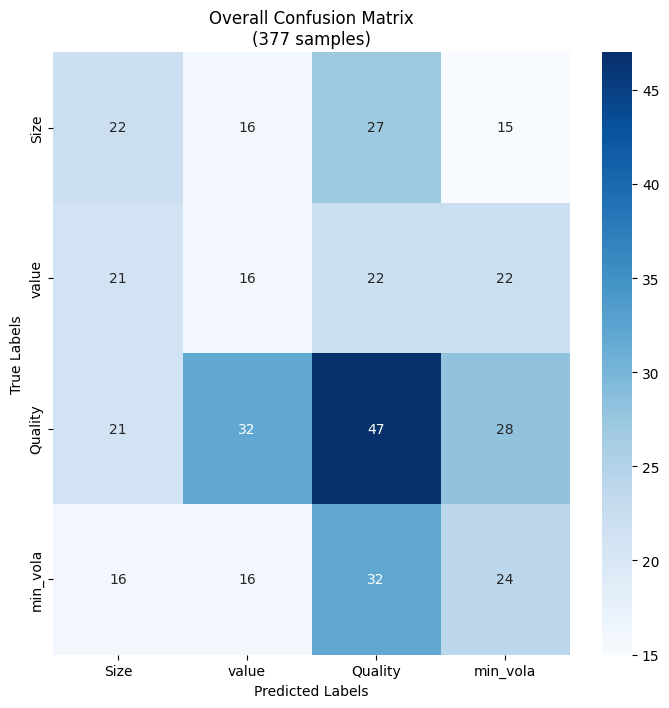

Regime,Accuracy,Precision,Recall,F1 Score,Samples
Overall,0.2891,0.2889,0.2891,0.289,377


Factor,Predicted Count,Correct Count,Factor Accuracy (%)
Size,80,22,27.5%
value,80,16,20.0%
Quality,128,47,36.72%
min_vola,89,24,26.97%


In [795]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML

# ----- Part A: Confusion Matrix & Overall Performance Metrics -----

# Use FACTORS directly as labels
labels = FACTORS

# Extract actual and predicted winners
all_true = results_df['Actual_Winner']
all_pred = results_df['Predicted_Winner']

# Get unique regimes if regime split is active
if use_regime_split:
    all_regimes = results_df['Regime'].unique()
else:
    all_regimes = []

# Set number of subplots: one overall plus one per regime if needed
num_cols = 1 if not use_regime_split else len(all_regimes) + 1
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(8 if num_cols == 1 else 19.5, 8))
if num_cols == 1:
    axes = [axes]

# 1. Overall confusion matrix
cm_total = confusion_matrix(all_true, all_pred, labels=labels)
sns.heatmap(cm_total, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
total_samples = len(all_true)
axes[0].set_title(f"Overall Confusion Matrix\n({total_samples} samples)")

# Prepare a list for metrics summary
metrics_summary = []

# Overall metrics
overall_metrics = {
    "Regime": "Overall",
    "Accuracy": accuracy_score(all_true, all_pred),
    "Precision": precision_score(all_true, all_pred, average='weighted', zero_division=0),
    "Recall": recall_score(all_true, all_pred, average='weighted', zero_division=0),
    "F1 Score": f1_score(all_true, all_pred, average='weighted', zero_division=0),
    "Samples": total_samples
}
metrics_summary.append(overall_metrics)

# 2. Per-regime confusion matrices and metrics (if regime split is active)
if use_regime_split:
    for i, regime in enumerate(all_regimes):
        regime_mask = (results_df['Regime'] == regime)
        regime_true = all_true[regime_mask]
        regime_pred = all_pred[regime_mask]

        if len(regime_true) == 0:
            print(f"\nNo samples for regime '{regime}'. Skipping confusion matrix.")
            continue

        cm_regime = confusion_matrix(regime_true, regime_pred, labels=labels)
        sns.heatmap(cm_regime, annot=True, fmt='d', cmap="Blues",
                    xticklabels=labels, yticklabels=labels, ax=axes[i+1])
        axes[i+1].set_xlabel("Predicted Labels")
        axes[i+1].set_ylabel("True Labels")
        axes[i+1].set_title(f"{regime} Regime\n({len(regime_true)} samples)")

        regime_metrics = {
            "Regime": regime,
            "Accuracy": accuracy_score(regime_true, regime_pred),
            "Precision": precision_score(regime_true, regime_pred, average='weighted', zero_division=0),
            "Recall": recall_score(regime_true, regime_pred, average='weighted', zero_division=0),
            "F1 Score": f1_score(regime_true, regime_pred, average='weighted', zero_division=0),
            "Samples": len(regime_true)
        }
        metrics_summary.append(regime_metrics)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(wspace=0.3)
plt.show()

# Convert overall metrics summary to DataFrame and round values
metrics_df = pd.DataFrame(metrics_summary)
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].round(4)

# Build HTML table for overall performance metrics
html_overall = f"""
<h3>Overall Performance Metrics Summary</h3>
<table border="1" cellpadding="5">
    <tr>
        <th>Regime</th>
        <th>Accuracy</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1 Score</th>
        <th>Samples</th>
    </tr>
"""
for _, row in metrics_df.iterrows():
    html_overall += f"""
    <tr>
        <td>{row['Regime']}</td>
        <td>{row['Accuracy']}</td>
        <td>{row['Precision']}</td>
        <td>{row['Recall']}</td>
        <td>{row['F1 Score']}</td>
        <td>{row['Samples']}</td>
    </tr>
"""
html_overall += "</table>"

explanations = {
    "Accuracy": "Proportion of correct predictions.",
    "Precision": "How many predicted positives were actually correct?",
    "Recall": "How many actual positives were correctly predicted?",
    "F1 Score": "Harmonic mean of precision & recall.",
    "Samples": "Number of test samples in this regime."
}
html_overall += "<h4>Metric Explanations:</h4><ul>"
for metric, desc in explanations.items():
    html_overall += f"<li><strong>{metric}:</strong> {desc}</li>"
html_overall += "</ul>"

display(HTML(html_overall))


# ----- Part B: Factor-Level Accuracy from Overall Confusion Matrix -----
factor_data = []
for i, factor in enumerate(labels):
    predicted_count = cm_total[:, i].sum()  # sum of column i
    correct_count = cm_total[i, i]         # diagonal entry
    if predicted_count > 0:
        factor_accuracy = correct_count / predicted_count * 100
    else:
        factor_accuracy = 0.0

    factor_data.append({
        "Factor": factor,
        "Predicted Count": int(predicted_count),
        "Correct Count": int(correct_count),
        "Factor Accuracy (%)": round(factor_accuracy, 2)
    })

factor_df = pd.DataFrame(factor_data)

html_factor = f"""
<h3>Factor-Level Accuracy (From Overall Confusion Matrix)</h3>
<table border="1" cellpadding="5">
    <tr>
        <th>Factor</th>
        <th>Predicted Count</th>
        <th>Correct Count</th>
        <th>Factor Accuracy (%)</th>
    </tr>
"""
for _, row in factor_df.iterrows():
    html_factor += f"""
    <tr>
        <td>{row['Factor']}</td>
        <td>{row['Predicted Count']}</td>
        <td>{row['Correct Count']}</td>
        <td>{row['Factor Accuracy (%)']}%</td>
    </tr>
"""
html_factor += "</table>"

html_factor += """
<h4>Definition</h4>
<ul>
  <li><strong>Predicted Count:</strong> Sum of the corresponding column in the confusion matrix (times predicted this factor).</li>
  <li><strong>Correct Count:</strong> Diagonal entry for this factor in the matrix (times predicted factor = actual factor).</li>
  <li><strong>Factor Accuracy:</strong> (Correct Count / Predicted Count) * 100.</li>
</ul>
"""

display(HTML(html_factor))


##Feature importance

<ipython-input-796-d99f00845294>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4.0)


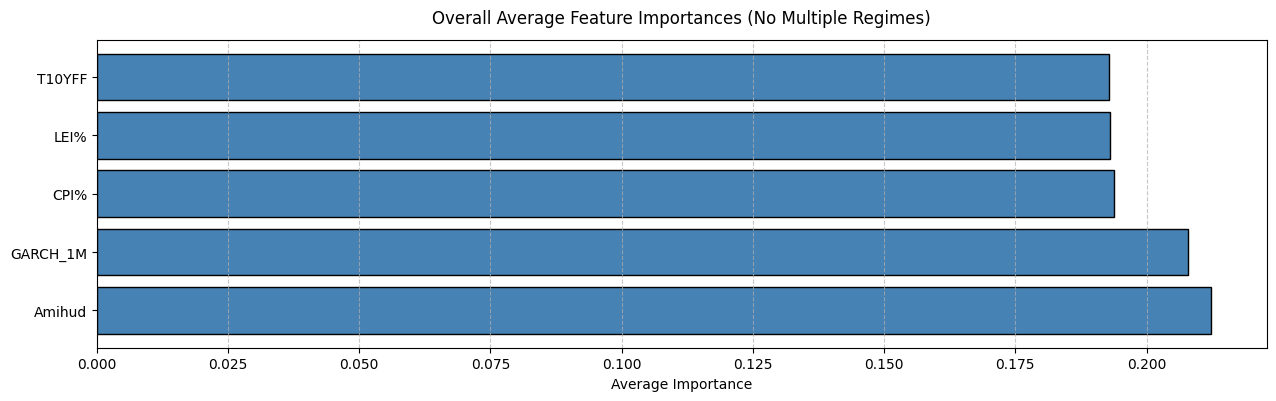

In [796]:
# --- Code cell 26 ---
# 2. Regime-Specific Feature Importances (Dynamic Version)
# ========================================================

import numpy as np
import matplotlib.pyplot as plt

# Get the unique regimes from results_df (already converted to string names)
existing_regimes = results_df['Regime'].unique()
n_regimes = len(existing_regimes)

# Dynamically get the number of features from the data
n_features = len(results_df['Feature_Importances'].iloc[0])  # Actual feature count

# Robust feature name handling:
try:
    # Validate FEATURES list length matches actual features
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features})")
        print("Using auto-generated feature names instead")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate descriptive feature names if there's a mismatch or error
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features")

# Compute overall average feature importances across all predictions
overall_avg_fi = np.vstack(results_df['Feature_Importances'].values).mean(axis=0)

# Calculate regime-specific average feature importances
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = results_df[results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# Sort features by overall importance in descending order
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # bounds check
sorted_features = [feature_names[i] for i in sorted_idx]

# 1) If we have more than one unique regime, make an overall + multiple regime subplots
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One for overall, one per regime
    # Figure height depends on number of plots and number of features
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]  # ensure iterable

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Plots ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)

# 2) Otherwise, if there's only zero or one regime, show only the overall chart
else:
    total_plots = 1
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )

    # --- Overall Feature Importances ---
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Provide extra space on the left for feature labels
plt.show()


##Allocation chart

Date Range: 1993-07-30 00:00:00 to 2024-11-30 00:00:00


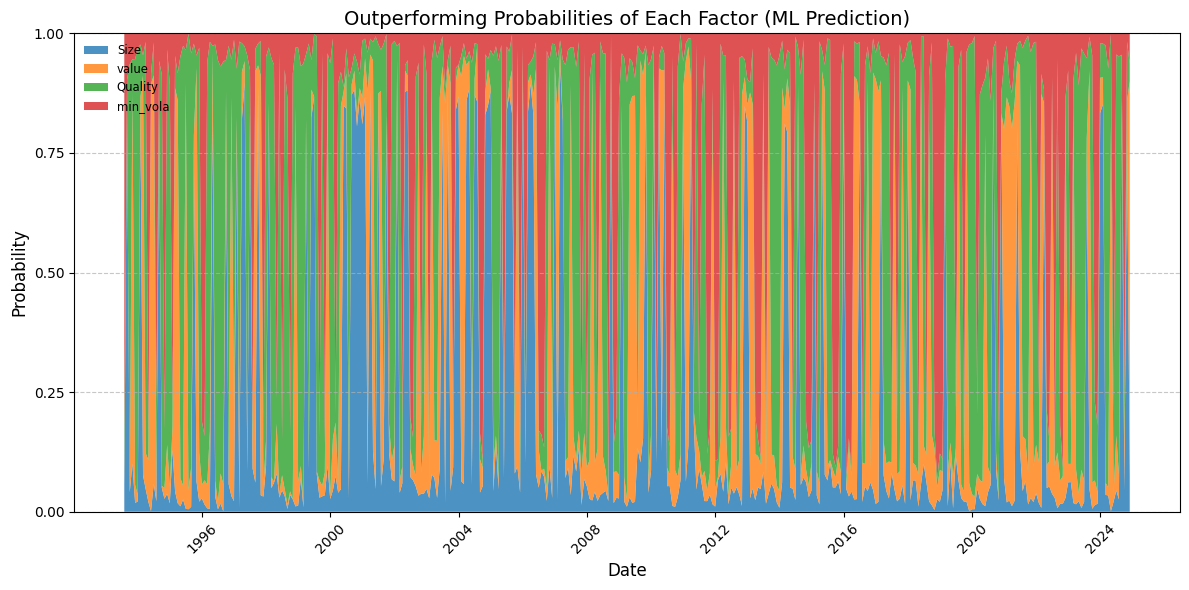

In [797]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Convert "Predicted_month" to datetime (assuming the format is '%Y-%m'):
probability_dates = pd.to_datetime(
    results_df["Predicted_month"],
    format='%Y-%m'
)

# 2) Drop rows with unparseable dates if needed
if probability_dates.isna().any():
    print("Warning: Some dates could not be parsed. Dropping those rows.")
    results_df = results_df.loc[~probability_dates.isna()].copy()
    probability_dates = probability_dates.dropna()

# 3) Extract the probability arrays and build a DataFrame
full_probs = np.vstack(results_df["Predicted_Probabilities"].values)
probability_df = pd.DataFrame(full_probs, columns=FACTORS)
probability_df["Date"] = probability_dates
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

# 4) Check date range
print("Date Range:", probability_df["Date"].min(), "to", probability_df["Date"].max())

# 5) Plot the probabilities in a stack plot
plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df["Date"],
    [probability_df[col] for col in FACTORS],
    labels=FACTORS,
    alpha=0.8
)

plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)

# Manually set y-axis ticks at 0, 0.25, 0.5, 0.75, 1
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Factor weight analysis

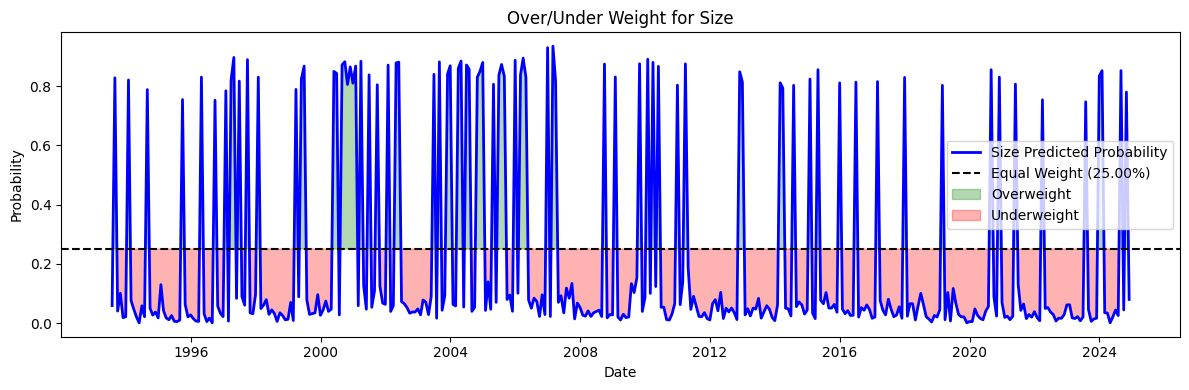

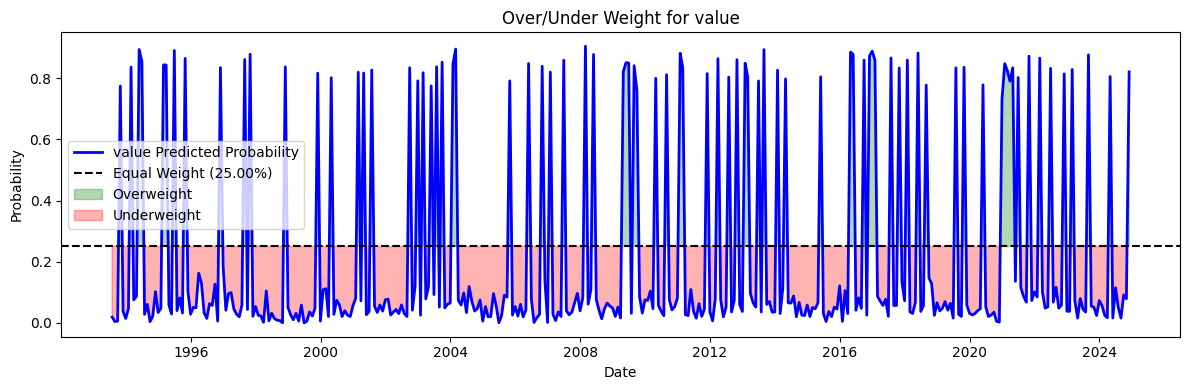

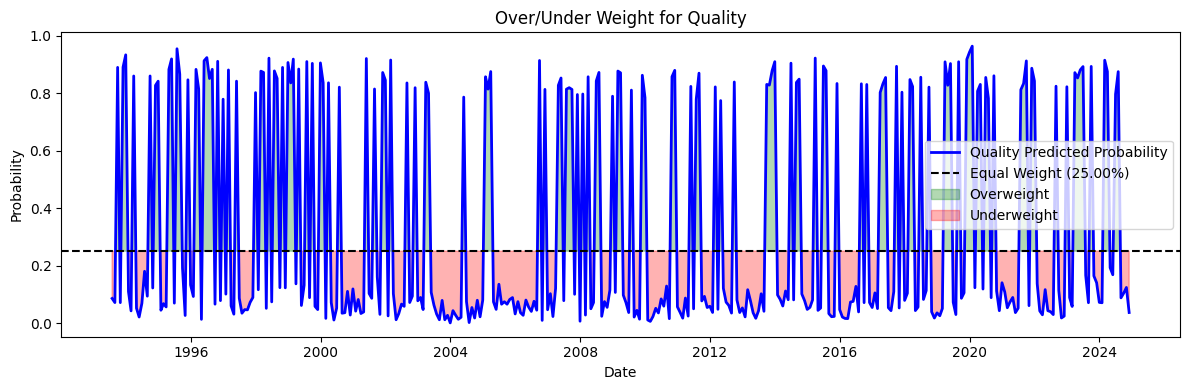

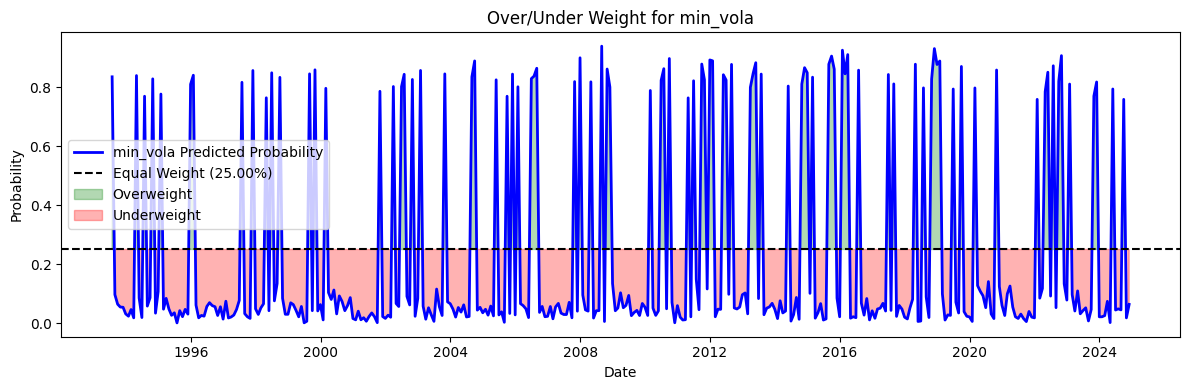

In [798]:
# Set the date range for viewing
start_date = "1968-07-30"
end_date = "2024-11-30"

# Ensure that the "Date" column is in datetime format if it's not already
probability_df["Date"] = pd.to_datetime(probability_df["Date"])

# Filter the dataframe to include only the rows between the set dates
mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
filtered_df = probability_df.loc[mask]

# Define the equal weight value (static equal weight for each factor)
equal_weight = 1 / len(FACTORS)  # For example, if 5 factors then equal_weight = 0.20

import matplotlib.pyplot as plt

# Loop over each factor in FACTORS and create a separate chart
for factor in FACTORS:
    plt.figure(figsize=(12, 4))

    # Plot the predicted probability for the current factor using the filtered data
    plt.plot(filtered_df["Date"], filtered_df[factor],
             label=f"{factor} Predicted Probability", color='blue', linewidth=2)

    # Plot the static equal weight line
    plt.axhline(equal_weight, color='black', linestyle='--',
                label=f"Equal Weight ({equal_weight:.2%})")

    # Shade the area where the predicted probability is above the equal weight (Overweight)
    plt.fill_between(filtered_df["Date"],
                     filtered_df[factor],
                     equal_weight,
                     where=(filtered_df[factor] > equal_weight),
                     interpolate=True, color='green', alpha=0.3, label='Overweight')

    # Shade the area where the predicted probability is below the equal weight (Underweight)
    plt.fill_between(filtered_df["Date"],
                     filtered_df[factor],
                     equal_weight,
                     where=(filtered_df[factor] < equal_weight),
                     interpolate=True, color='red', alpha=0.3, label='Underweight')

    # Set chart title and labels
    plt.title(f"Over/Under Weight for {factor}")
    plt.xlabel("Date")
    plt.ylabel("Probability")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


##Total outperforming probabilities

In [799]:
import pandas as pd

avg_probs = probability_df[FACTORS].mean()
avg_probs_df = avg_probs.reset_index()
avg_probs_df.columns = ['Factor', 'Average Probability']


print("Average Outperforming Probabilities Over Time:")
print(avg_probs_df)

Average Outperforming Probabilities Over Time:
     Factor  Average Probability
0      Size             0.214186
1     value             0.217612
2   Quality             0.334611
3  min_vola             0.233590


##Start & end dates


In [800]:
# Ensure the 'Predicted_month' column is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Get the earliest date from the 'Predicted_month' column
first_date = results_df['Predicted_month'].min()
last_date = results_df['Predicted_month'].max()

print("First date Predicted_month column in results_df:", first_date)
print("Last date in Predicted_month column results_df:", last_date)

First date Predicted_month column in results_df: 1993-07-30 00:00:00
Last date in Predicted_month column results_df: 2024-11-30 00:00:00


##Cumulative returns

In [802]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# Create local copies so that the original DataFrames remain unchanged
results_df_local = results_df.copy()
df_local = df.copy()

# -------------------------------------
# 1. Standardize date columns to month-end (local copies only)
# -------------------------------------
results_df_local['Predicted_month'] = pd.to_datetime(results_df_local['Predicted_month']) + pd.offsets.MonthEnd(0)
df_local['Date'] = pd.to_datetime(df_local['Date']) + pd.offsets.MonthEnd(0)

# -------------------------------------
# Define your dynamic date range (month-end)
# -------------------------------------
start_date = pd.to_datetime('2010-01-30') + pd.offsets.MonthEnd(0)
end_date   = pd.to_datetime('2024-12-30') + pd.offsets.MonthEnd(0)

# -------------------------------------
# Part 1: Process results_df for ML Allocated Strategy
# -------------------------------------
filtered_df = results_df_local.loc[
    (results_df_local['Predicted_month'] >= start_date) & (results_df_local['Predicted_month'] <= end_date),
    ['Predicted_month', 'Allocated_Return']
].sort_values('Predicted_month').copy()

filtered_df = filtered_df.rename(columns={'Allocated_Return': 'ML Allocated Strategy Return'})
filtered_df['ML Allocated Strategy Return Shifted'] = filtered_df['ML Allocated Strategy Return'].shift(1, fill_value=0)
filtered_df['ML Cumulative Allocated Return'] = (1 + filtered_df['ML Allocated Strategy Return Shifted']).cumprod()

# -------------------------------------
# Part 2: Process df for Benchmark, Equal Factor Weight, and Theoretical Maximum
# -------------------------------------
df_filtered = df_local.loc[
    (df_local['Date'] >= start_date) & (df_local['Date'] <= end_date)
].copy().sort_values('Date')

# Process Benchmark returns (assuming BENCHMARK is defined, e.g., BENCHMARK = ['Us_standard'])
benchmark_col = BENCHMARK[0]
df_filtered[f'{benchmark_col} Shifted'] = df_filtered[benchmark_col].shift(1, fill_value=0)
df_filtered['Benchmark Cumulative Returns'] = (1 + df_filtered[f'{benchmark_col} Shifted']).cumprod()

# Calculate the Equal Factor Weight Strategy:
if 'RF' in FACTORS:
    # Calculate including RF
    df_filtered['Equal Factor Weight Strategy w/ RF'] = df_filtered[FACTORS].mean(axis=1)
    df_filtered['Equal Factor Weight Strategy w/ RF Shifted'] = df_filtered['Equal Factor Weight Strategy w/ RF'].shift(1, fill_value=0)
    df_filtered['Equal Factor Weight Cumulative Return w/ RF'] = (1 + df_filtered['Equal Factor Weight Strategy w/ RF Shifted']).cumprod()

    # Calculate excluding RF
    factors_ex_rf = [f for f in FACTORS if f != 'RF']
    df_filtered['Equal Factor Weight Strategy w/o RF'] = df_filtered[factors_ex_rf].mean(axis=1)
    df_filtered['Equal Factor Weight Strategy w/o RF Shifted'] = df_filtered['Equal Factor Weight Strategy w/o RF'].shift(1, fill_value=0)
    df_filtered['Equal Factor Weight Cumulative Return w/o RF'] = (1 + df_filtered['Equal Factor Weight Strategy w/o RF Shifted']).cumprod()
else:
    df_filtered['Equal Factor Weight Strategy'] = df_filtered[FACTORS].mean(axis=1)
    df_filtered['Equal Factor Weight Strategy Shifted'] = df_filtered['Equal Factor Weight Strategy'].shift(1, fill_value=0)
    df_filtered['Equal Factor Weight Cumulative Return'] = (1 + df_filtered['Equal Factor Weight Strategy Shifted']).cumprod()

# Calculate the Theoretical Maximum Strategy by choosing the maximum return among FACTORS
df_filtered['Theoretical Max Strategy'] = df_filtered[FACTORS].max(axis=1)
df_filtered['Theoretical Max Strategy Shifted'] = df_filtered['Theoretical Max Strategy'].shift(1, fill_value=0)
df_filtered['Theoretical Max Cumulative Return'] = (1 + df_filtered['Theoretical Max Strategy Shifted']).cumprod()

# -------------------------------------
# Part 3: Rebase Benchmark, Equal Factor Weight, and Theoretical Maximum Cumulative Returns
# -------------------------------------
ml_start_date = filtered_df['Predicted_month'].min()

start_value_benchmark = df_filtered.loc[df_filtered['Date'] == ml_start_date, 'Benchmark Cumulative Returns'].values[0]
df_filtered['Benchmark Cumulative Returns Rebased'] = df_filtered['Benchmark Cumulative Returns'] / start_value_benchmark

if 'RF' in FACTORS:
    start_value_equal_rf = df_filtered.loc[df_filtered['Date'] == ml_start_date, 'Equal Factor Weight Cumulative Return w/ RF'].values[0]
    df_filtered['Equal Factor Weight Cumulative Return w/ RF Rebased'] = df_filtered['Equal Factor Weight Cumulative Return w/ RF'] / start_value_equal_rf

    start_value_equal_no_rf = df_filtered.loc[df_filtered['Date'] == ml_start_date, 'Equal Factor Weight Cumulative Return w/o RF'].values[0]
    df_filtered['Equal Factor Weight Cumulative Return w/o RF Rebased'] = df_filtered['Equal Factor Weight Cumulative Return w/o RF'] / start_value_equal_no_rf
else:
    start_value_equal = df_filtered.loc[df_filtered['Date'] == ml_start_date, 'Equal Factor Weight Cumulative Return'].values[0]
    df_filtered['Equal Factor Weight Cumulative Return Rebased'] = df_filtered['Equal Factor Weight Cumulative Return'] / start_value_equal

start_value_theoretical = df_filtered.loc[df_filtered['Date'] == ml_start_date, 'Theoretical Max Cumulative Return'].values[0]
df_filtered['Theoretical Max Cumulative Return Rebased'] = df_filtered['Theoretical Max Cumulative Return'] / start_value_theoretical

# -------------------------------------
# Part 4: Merge the DataFrames and remove NaNs
# -------------------------------------
if 'RF' in FACTORS:
    merged_df = pd.merge(
        filtered_df,
        df_filtered[['Date', 'Benchmark Cumulative Returns Rebased',
                     'Equal Factor Weight Strategy w/ RF',
                     'Equal Factor Weight Strategy w/o RF',
                     'Theoretical Max Strategy',
                     'Equal Factor Weight Cumulative Return w/ RF Rebased',
                     'Equal Factor Weight Cumulative Return w/o RF Rebased',
                     'Theoretical Max Cumulative Return Rebased']],
        left_on='Predicted_month',
        right_on='Date',
        how='left'
    )
else:
    merged_df = pd.merge(
        filtered_df,
        df_filtered[['Date', 'Benchmark Cumulative Returns Rebased',
                     'Equal Factor Weight Strategy',
                     'Theoretical Max Strategy',
                     'Equal Factor Weight Cumulative Return Rebased',
                     'Theoretical Max Cumulative Return Rebased']],
        left_on='Predicted_month',
        right_on='Date',
        how='left'
    )

merged_df.drop(columns=['Date'], inplace=True)
merged_df = merged_df.dropna()

# -------------------------------------
# Split into Two Tables: Returns and Cumulative Returns
# -------------------------------------
if 'RF' in FACTORS:
    returns_cols = ['Predicted_month', 'ML Allocated Strategy Return',
                    'Equal Factor Weight Strategy w/ RF', 'Equal Factor Weight Strategy w/o RF',
                    'Theoretical Max Strategy']
    cumulative_cols = ['Predicted_month', 'ML Cumulative Allocated Return',
                       'Benchmark Cumulative Returns Rebased',
                       'Equal Factor Weight Cumulative Return w/ RF Rebased', 'Equal Factor Weight Cumulative Return w/o RF Rebased',
                       'Theoretical Max Cumulative Return Rebased']
else:
    returns_cols = ['Predicted_month', 'ML Allocated Strategy Return',
                    'Equal Factor Weight Strategy', 'Theoretical Max Strategy']
    cumulative_cols = ['Predicted_month', 'ML Cumulative Allocated Return',
                       'Benchmark Cumulative Returns Rebased',
                       'Equal Factor Weight Cumulative Return Rebased', 'Theoretical Max Cumulative Return Rebased']

returns_df = merged_df[returns_cols].copy()
cumulative_df = merged_df[cumulative_cols].copy()

# Round numeric columns to 3 decimals
for df_temp in [returns_df, cumulative_df]:
    numeric_cols = df_temp.select_dtypes(include=[np.number]).columns
    df_temp[numeric_cols] = df_temp[numeric_cols].round(3)

# -------------------------------------
# Display Results in Two Separate Tables
# -------------------------------------
display(HTML("<h3>Returns Table</h3>"))
display(returns_df)

display(HTML("<h3>Cumulative Returns Table</h3>"))
display(cumulative_df)


,Predicted_month,ML Allocated Strategy Return,Equal Factor Weight Strategy,Theoretical Max Strategy
0,2010-01-31,-0.031,-0.033,-0.027
1,2010-02-28,0.022,0.026,0.033
2,2010-03-31,0.052,0.049,0.063
3,2010-04-30,0.018,0.014,0.020
4,2010-05-31,-0.069,-0.074,-0.061
...,...,...,...,...
174,2024-07-31,0.007,0.030,0.047
175,2024-08-31,0.032,0.032,0.048
176,2024-09-30,0.005,0.010,0.016
177,2024-10-31,-0.015,-0.015,-0.010


,Predicted_month,ML Cumulative Allocated Return,Benchmark Cumulative Returns Rebased,Equal Factor Weight Cumulative Return Rebased,Theoretical Max Cumulative Return Rebased
0,2010-01-31,1.000,1.000,1.000,1.000
1,2010-02-28,0.969,0.964,0.967,0.973
2,2010-03-31,0.990,0.991,0.992,1.005
3,2010-04-30,1.042,1.049,1.041,1.068
4,2010-05-31,1.061,1.065,1.055,1.090
...,...,...,...,...,...
174,2024-07-31,5.251,4.894,4.508,39.720
175,2024-08-31,5.287,4.951,4.643,41.599
176,2024-09-30,5.458,5.064,4.794,43.584
177,2024-10-31,5.485,5.167,4.840,44.292


##Cumulative returns chart

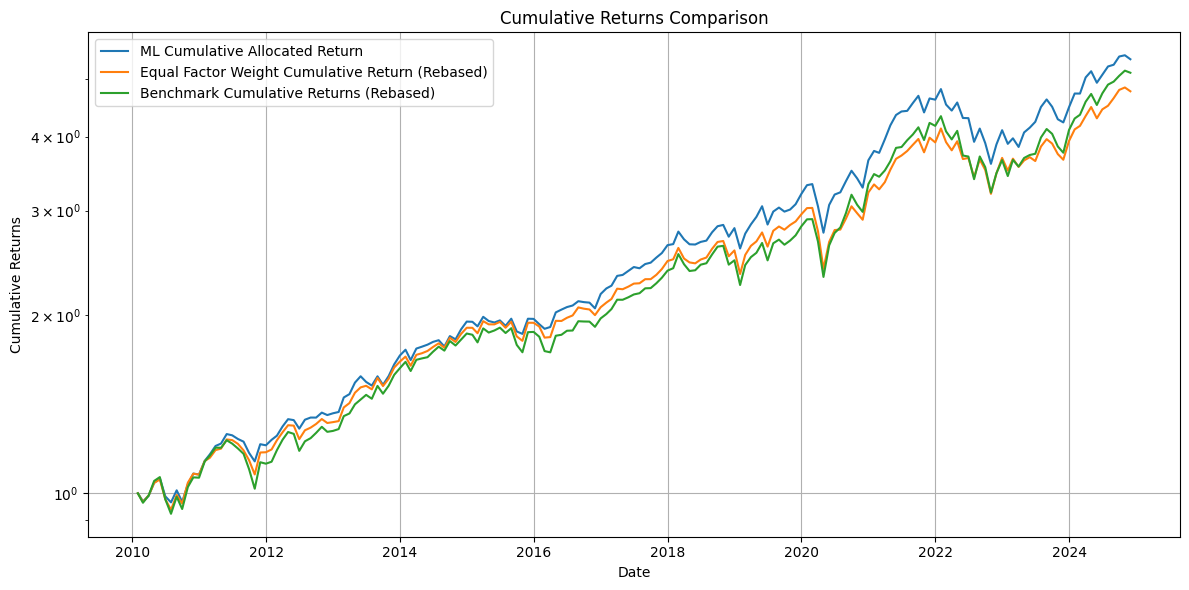

In [803]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the DataFrame is sorted by Predicted_month
merged_df = merged_df.sort_values('Predicted_month')

plt.figure(figsize=(12, 6))

# Plot ML Cumulative Allocated Return
plt.plot(
    merged_df['Predicted_month'],
    merged_df['ML Cumulative Allocated Return'],
    label='ML Cumulative Allocated Return'
)

# Plot Equal Factor Weight Cumulative Return(s)
if 'RF' in FACTORS:
    # Plot the version including RF
    plt.plot(
        merged_df['Predicted_month'],
        merged_df['Equal Factor Weight Cumulative Return w/ RF Rebased'],
        label='Equal Factor Weight Cumulative Return (w/ RF)'
    )
    # Plot the version excluding RF
    plt.plot(
        merged_df['Predicted_month'],
        merged_df['Equal Factor Weight Cumulative Return w/o RF Rebased'],
        label='Equal Factor Weight Cumulative Return (w/o RF)'
    )
else:
    plt.plot(
        merged_df['Predicted_month'],
        merged_df['Equal Factor Weight Cumulative Return Rebased'],
        label='Equal Factor Weight Cumulative Return (Rebased)'
    )

# Only plot Benchmark if show_benchmark is True
if show_benchmark:
    plt.plot(
        merged_df['Predicted_month'],
        merged_df['Benchmark Cumulative Returns Rebased'],
        label='Benchmark Cumulative Returns (Rebased)'
    )

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')

# Set y-axis to log scale for better visualization
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##PERFORMANCE METRICS

In [804]:
import numpy as np
import pandas as pd

# --- PERFORMANCE METRICS ---

# For the ML Allocated Strategy:
ml_returns = merged_df['ML Allocated Strategy Return']
ml_mean_monthly = ml_returns.mean()
ml_std_monthly  = ml_returns.std()
ml_annualized_return = ml_mean_monthly * 12
ml_annualized_vol    = ml_std_monthly * np.sqrt(12)
ml_sharpe            = ml_annualized_return / ml_annualized_vol

print("\nPERFORMANCE METRICS:\n")
print("ML Allocated Strategy:")
print(f"  Annualized Return:      {ml_annualized_return:.2%}")
print(f"  Annualized Volatility:  {ml_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {ml_sharpe:.2f}\n")

# For the Equal Factor Weight Strategy:
if 'RF' in FACTORS:
    # With RF
    equal_returns_with_rf = merged_df['Equal Factor Weight Strategy w/ RF']
    equal_mean_monthly_with_rf = equal_returns_with_rf.mean()
    equal_std_monthly_with_rf  = equal_returns_with_rf.std()
    equal_annualized_return_with_rf = equal_mean_monthly_with_rf * 12
    equal_annualized_vol_with_rf    = equal_std_monthly_with_rf * np.sqrt(12)
    equal_sharpe_with_rf            = equal_annualized_return_with_rf / equal_annualized_vol_with_rf

    print("Equal Factor Weight Strategy (with RF):")
    print(f"  Annualized Return:      {equal_annualized_return_with_rf:.2%}")
    print(f"  Annualized Volatility:  {equal_annualized_vol_with_rf:.2%}")
    print(f"  Sharpe Ratio:           {equal_sharpe_with_rf:.2f}\n")

    # Without RF
    equal_returns_without_rf = merged_df['Equal Factor Weight Strategy w/o RF']
    equal_mean_monthly_without_rf = equal_returns_without_rf.mean()
    equal_std_monthly_without_rf  = equal_returns_without_rf.std()
    equal_annualized_return_without_rf = equal_mean_monthly_without_rf * 12
    equal_annualized_vol_without_rf    = equal_std_monthly_without_rf * np.sqrt(12)
    equal_sharpe_without_rf            = equal_annualized_return_without_rf / equal_annualized_vol_without_rf

    print("Equal Factor Weight Strategy (without RF):")
    print(f"  Annualized Return:      {equal_annualized_return_without_rf:.2%}")
    print(f"  Annualized Volatility:  {equal_annualized_vol_without_rf:.2%}")
    print(f"  Sharpe Ratio:           {equal_sharpe_without_rf:.2f}\n")
else:
    equal_returns = merged_df['Equal Factor Weight Strategy']
    equal_mean_monthly = equal_returns.mean()
    equal_std_monthly  = equal_returns.std()
    equal_annualized_return = equal_mean_monthly * 12
    equal_annualized_vol    = equal_std_monthly * np.sqrt(12)
    equal_sharpe            = equal_annualized_return / equal_annualized_vol

    print("Equal Factor Weight Strategy:")
    print(f"  Annualized Return:      {equal_annualized_return:.2%}")
    print(f"  Annualized Volatility:  {equal_annualized_vol:.2%}")
    print(f"  Sharpe Ratio:           {equal_sharpe:.2f}\n")

# --- MAXIMUM DRAWDOWN CALCULATIONS ---
# Compute wealth indexes starting at 1 for each strategy.
wealth_ml = (1 + merged_df['ML Allocated Strategy Return']).cumprod()

if 'RF' in FACTORS:
    wealth_equal_with_rf = (1 + merged_df['Equal Factor Weight Strategy w/ RF']).cumprod()
    wealth_equal_without_rf = (1 + merged_df['Equal Factor Weight Strategy w/o RF']).cumprod()
else:
    wealth_equal = (1 + merged_df['Equal Factor Weight Strategy']).cumprod()

# Compute drawdown series for each strategy:
drawdown_ml = wealth_ml / wealth_ml.cummax() - 1

if 'RF' in FACTORS:
    drawdown_equal_with_rf = wealth_equal_with_rf / wealth_equal_with_rf.cummax() - 1
    drawdown_equal_without_rf = wealth_equal_without_rf / wealth_equal_without_rf.cummax() - 1
else:
    drawdown_equal = wealth_equal / wealth_equal.cummax() - 1

print("MAXIMUM DRAWDOWNS:\n")
print("ML Allocated Strategy Max Drawdown:       ", f"{drawdown_ml.min():.2%}")
if 'RF' in FACTORS:
    print("Equal Factor Weight Strategy (with RF) Max Drawdown:  ", f"{drawdown_equal_with_rf.min():.2%}")
    print("Equal Factor Weight Strategy (without RF) Max Drawdown:  ", f"{drawdown_equal_without_rf.min():.2%}")
else:
    print("Equal Factor Weight Strategy Max Drawdown:  ", f"{drawdown_equal.min():.2%}")



PERFORMANCE METRICS:

ML Allocated Strategy:
  Annualized Return:      12.58%
  Annualized Volatility:  12.81%
  Sharpe Ratio:           0.98

Equal Factor Weight Strategy:
  Annualized Return:      11.76%
  Annualized Volatility:  13.33%
  Sharpe Ratio:           0.88

MAXIMUM DRAWDOWNS:

ML Allocated Strategy Max Drawdown:        -25.21%
Equal Factor Weight Strategy Max Drawdown:   -22.43%


##Drawdown chart

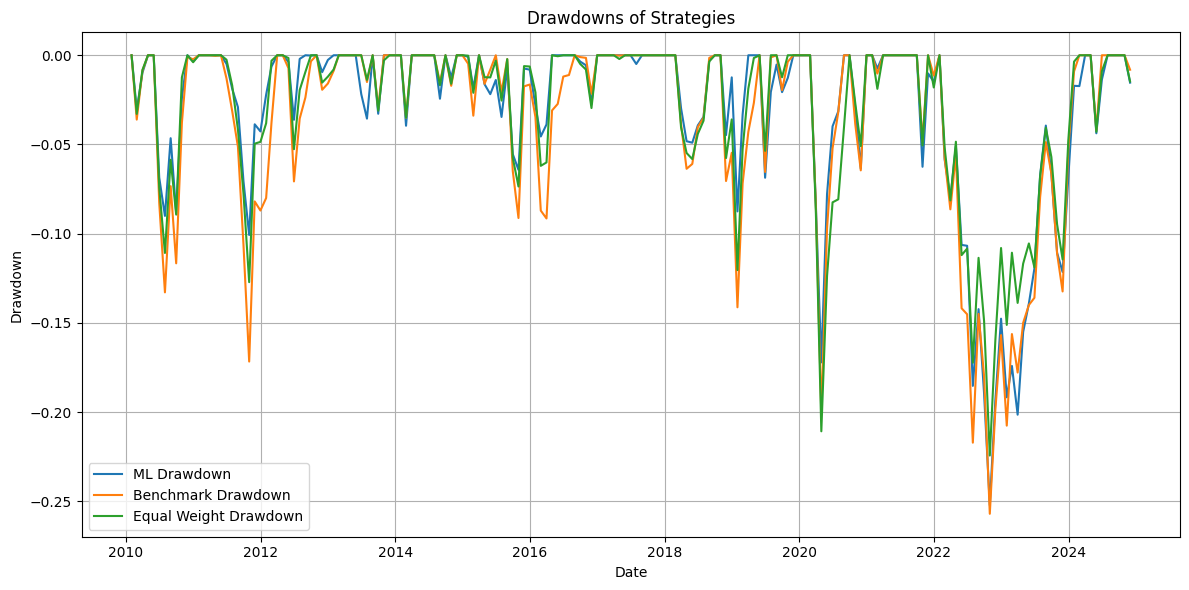

In [805]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Toggle Options (set these before any calculations) ---
show_benchmark_drawdown = True

# For Equal Factor Weight Drawdown toggles:
if 'RF' in FACTORS:
    show_equal_weight_drawdown_rf = True    # Toggle for Equal Weight drawdown (with RF)
    show_equal_weight_drawdown_no_rf = True   # Toggle for Equal Weight drawdown (without RF)
else:
    show_equal_weight_drawdown = True         # Toggle for Equal Weight drawdown

# --- Compute Drawdowns for Each Strategy ---
# ML Allocated Strategy Drawdown (using the ML Cumulative Allocated Return)
merged_df['ML Drawdown'] = merged_df['ML Cumulative Allocated Return'] / merged_df['ML Cumulative Allocated Return'].cummax() - 1

# Benchmark Drawdown (using the Benchmark Cumulative Returns Rebased)
merged_df['Benchmark Drawdown'] = merged_df['Benchmark Cumulative Returns Rebased'] / merged_df['Benchmark Cumulative Returns Rebased'].cummax() - 1

if 'RF' in FACTORS:
    # Equal Factor Weight Drawdowns for strategies with and without RF:
    merged_df['Equal Weight Drawdown w/ RF'] = merged_df['Equal Factor Weight Cumulative Return w/ RF Rebased'] / \
        merged_df['Equal Factor Weight Cumulative Return w/ RF Rebased'].cummax() - 1
    merged_df['Equal Weight Drawdown w/o RF'] = merged_df['Equal Factor Weight Cumulative Return w/o RF Rebased'] / \
        merged_df['Equal Factor Weight Cumulative Return w/o RF Rebased'].cummax() - 1
else:
    merged_df['Equal Weight Drawdown'] = merged_df['Equal Factor Weight Cumulative Return Rebased'] / \
        merged_df['Equal Factor Weight Cumulative Return Rebased'].cummax() - 1

# --- Define the date range for plotting ---
start_date = pd.to_datetime('2000-01-01')  # change as needed
end_date = pd.to_datetime('2024-12-31')      # change as needed

# Filter the DataFrame for the specified timeframe
plot_df = merged_df[(merged_df['Predicted_month'] >= start_date) & (merged_df['Predicted_month'] <= end_date)]

# --- Plot the Drawdowns ---
plt.figure(figsize=(12, 6))

# ML drawdown is always plotted.
plt.plot(plot_df['Predicted_month'], plot_df['ML Drawdown'], label='ML Drawdown')

if show_benchmark_drawdown:
    plt.plot(plot_df['Predicted_month'], plot_df['Benchmark Drawdown'], label='Benchmark Drawdown')

if 'RF' in FACTORS:
    if show_equal_weight_drawdown_rf:
        plt.plot(plot_df['Predicted_month'], plot_df['Equal Weight Drawdown w/ RF'], label='Equal Weight Drawdown (w/ RF)')
    if show_equal_weight_drawdown_no_rf:
        plt.plot(plot_df['Predicted_month'], plot_df['Equal Weight Drawdown w/o RF'], label='Equal Weight Drawdown (w/o RF)')
else:
    if show_equal_weight_drawdown:
        plt.plot(plot_df['Predicted_month'], plot_df['Equal Weight Drawdown'], label='Equal Weight Drawdown')

plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdowns of Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [806]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ----------------------------
# 1. Load the FF5 data and rename columns
# ----------------------------
xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")
df_factors = xls_file.parse("FF5")

# Expected order: Date, Mkt-RF, SMB, HML, RMW, CMA, RF
# Adjust these names if your Excel sheet uses different labels
df_factors.columns = ["Date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]

# Convert commas to dots, convert to float, and divide by 100
for col in ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]:
    df_factors[col] = df_factors[col].astype(str).str.replace(",", ".")
    df_factors[col] = pd.to_numeric(df_factors[col], errors="coerce") / 100.0

# Convert the Date column to datetime
df_factors["Date"] = pd.to_datetime(df_factors["Date"])

# ----------------------------
# 2. Merge FF5 data into merged_df
# ----------------------------
# Ensure merged_df['Predicted_month'] is datetime (and ideally at month-end)
# For a clean merge, both date columns should have the same frequency/format.
merged_df = merged_df.merge(
    df_factors,
    left_on="Predicted_month",
    right_on="Date",
    how="left"
)

# Drop the duplicate Date column from the merge
merged_df.drop(columns=["Date"], inplace=True)

# ----------------------------
# 3. Check that the RF column is present
# ----------------------------
print("Merged DataFrame columns:", merged_df.columns)

if "RF" not in merged_df.columns:
    # Try to find a column that might be the risk-free rate (case-insensitive)
    for col in merged_df.columns:
        if col.lower().strip() == "rf":
            merged_df.rename(columns={col: "RF"}, inplace=True)
            print(f"Renamed column {col} to 'RF'")
            break
    if "RF" not in merged_df.columns:
        raise KeyError("Risk-free rate column 'RF' not found in merged_df. "
                       "Please verify your FF5 sheet and column names.")

# ----------------------------
# 4. Create Excess Returns (subtract RF from strategy returns)
# ----------------------------
merged_df["ML Excess Return"] = merged_df["ML Allocated Strategy Return"] - merged_df["RF"]
merged_df["Equal Factor Weight Excess Return"] = merged_df["Equal Factor Weight Strategy"] - merged_df["RF"]

# ----------------------------
# 5. Prepare the regression data for ML Allocated Strategy
# ----------------------------
X_ml = merged_df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
X_ml = sm.add_constant(X_ml)
y_ml = merged_df["ML Excess Return"]

# Remove any rows with NaN or infinite values
df_reg_ml = pd.concat([y_ml, X_ml], axis=1)
df_reg_ml.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg_ml.dropna(inplace=True)
y_ml_clean = df_reg_ml["ML Excess Return"]
X_ml_clean = df_reg_ml.drop(columns=["ML Excess Return"])

model_ml = sm.OLS(y_ml_clean, X_ml_clean).fit()
print("Regression Results: ML Allocated Strategy (Excess) vs FF5 Factors")
print(model_ml.summary())

# ----------------------------
# 6. Prepare the regression data for Equal Factor Weight Strategy
# ----------------------------
X_eq = merged_df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
X_eq = sm.add_constant(X_eq)
y_eq = merged_df["Equal Factor Weight Excess Return"]

df_reg_eq = pd.concat([y_eq, X_eq], axis=1)
df_reg_eq.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg_eq.dropna(inplace=True)
y_eq_clean = df_reg_eq["Equal Factor Weight Excess Return"]
X_eq_clean = df_reg_eq.drop(columns=["Equal Factor Weight Excess Return"])

model_eq = sm.OLS(y_eq_clean, X_eq_clean).fit()
print("\nRegression Results: Equal Factor Weight Strategy (Excess) vs FF5 Factors")
print(model_eq.summary())

# ----------------------------
# 7. Annualize alpha and report t-stat and p-value
# ----------------------------
alpha_ml = model_ml.params["const"]
annualized_alpha_ml = alpha_ml * 12
t_alpha_ml = model_ml.tvalues["const"]
p_alpha_ml = model_ml.pvalues["const"]

alpha_eq = model_eq.params["const"]
annualized_alpha_eq = alpha_eq * 12
t_alpha_eq = model_eq.tvalues["const"]
p_alpha_eq = model_eq.pvalues["const"]

print("\nAnnualized Alpha Metrics:")
print("ML Allocated Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_ml:.2%}")
print(f"  T-statistic:      {t_alpha_ml:.2f}")
print(f"  P-value:          {p_alpha_ml:.4f}")

print("\nEqual Factor Weight Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_eq:.2%}")
print(f"  T-statistic:      {t_alpha_eq:.2f}")
print(f"  P-value:          {p_alpha_eq:.4f}")

Merged DataFrame columns: Index(['Predicted_month', 'ML Allocated Strategy Return',
       'ML Allocated Strategy Return Shifted',
       'ML Cumulative Allocated Return',
       'Benchmark Cumulative Returns Rebased', 'Equal Factor Weight Strategy',
       'Theoretical Max Strategy',
       'Equal Factor Weight Cumulative Return Rebased',
       'Theoretical Max Cumulative Return Rebased', 'ML Drawdown',
       'Benchmark Drawdown', 'Equal Weight Drawdown', 'Mkt-RF', 'SMB', 'HML',
       'RMW', 'CMA', 'RF'],
      dtype='object')
Regression Results: ML Allocated Strategy (Excess) vs FF5 Factors
                            OLS Regression Results                            
Dep. Variable:       ML Excess Return   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     183.6
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           1.98e-38
Ti

In [ ]:
import numpy as np
import pandas as pd

# Create a Year column from the 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

def annual_sharpe(group, col):
    """
    Calculate the annual Sharpe ratio for a given return column within a group (year).
    Annual Return is computed as the product of (1 + monthly return) minus 1.
    Annual Volatility is computed as the standard deviation of monthly returns * sqrt(12).
    The Sharpe ratio is then annual return divided by annual volatility.
    """
    # Compound monthly returns to get the annual return:
    annual_return = (1 + group[col]).prod() - 1
    # Annualize the monthly volatility:
    annual_vol = group[col].std() * np.sqrt(12)
    # Compute Sharpe ratio (assume risk-free rate = 0)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
    return sharpe

# Calculate annual Sharpe ratios for each strategy by grouping on 'Year'
sharpe_ml = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
sharpe_bench = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Mkt-RF'))
sharpe_equal = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Equal Factor Weight Strategy'))

# Combine the Sharpe ratios into one DataFrame
annual_sharpe_table = pd.DataFrame({
    'ML Sharpe Ratio': sharpe_ml,
    'Benchmark Sharpe Ratio': sharpe_bench,
    'Equal Weight Sharpe Ratio': sharpe_equal
})

# Optionally format the table for clearer display (2 decimal places)
annual_sharpe_table = annual_sharpe_table.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

print("Yearly Sharpe Ratios:")
print(annual_sharpe_table)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month' ---
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for Each Strategy by Grouping on 'Year' ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
annual_return_equal = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'Equal Factor Weight Strategy'))

# --- Compute Excess Return (ML - Equal Weight) ---
excess_return_ml = annual_return_ml - annual_return_equal

# --- Combine into a DataFrame ---
annual_metrics = pd.DataFrame({
    'ML Annual Return': annual_return_ml,
    'Equal Annual Return': annual_return_equal,
    'Excess Return (ML-EQ)': excess_return_ml
})

# --- Optionally Format the Metrics for Display ---
annual_metrics_formatted = annual_metrics.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)
print("Annual Metrics:")
print(annual_metrics_formatted)

# --- Plot Only the Excess Returns ---
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(annual_metrics.index, annual_metrics['Excess Return (ML-EQ)'],
        label='Excess Return (ML-EQ)', color='red', marker='s')
ax.set_xlabel('Year')
ax.set_ylabel('Excess Return (ML - Equal Weight)')
ax.set_title('Annual Excess Return: ML Allocated Strategy vs Equal Weight Strategy')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for the ML Allocated Strategy ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))

# --- Compute Annual Returns for Each Factor ---
factor_names = FACTORS
annual_returns_factors = {}
excess_returns = {}

for factor in factor_names:
    annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
    # Compute excess return: ML strategy annual return minus factor's annual return.
    excess_returns[factor] = annual_return_ml - annual_returns_factors[factor]

# Combine the computed metrics into a DataFrame for reference (optional)
annual_metrics = pd.DataFrame({'ML Annual Return': annual_return_ml})
for factor in factor_names:
    annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
    excess_returns[factor] = annual_return_ml - annual_returns_factors[factor]

print("Annual Metrics:")
print(annual_metrics.round(4))

# --- Plot Excess Returns for Each Factor ---
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)
axes = axes.flatten()

for idx, factor in enumerate(factor_names):
    ax = axes[idx]
    # Plot excess return: ML annual return minus factor annual return.
    ax.plot(excess_returns[factor].index, excess_returns[factor],
            label=f'Excess Return (ML - {factor})', marker='o')
    ax.set_title(f'Excess Return (ML - {factor})')
    ax.set_xlabel('Year')
    ax.set_ylabel('Excess Return')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= USER-DEFINED DATE RANGE =======
# Adjust these dates to view feature importances for a specific period
start_date = pd.to_datetime('2020-01-01')
end_date   = pd.to_datetime('2022-12-31')

# ======= Filter the Data =======
# Filter the results_df for the specified date range based on the 'Predicted_month' column
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
]

# ======= Get Unique Regimes and Feature Count =======
existing_regimes = filtered_results_df['Regime'].unique()
n_regimes = len(existing_regimes)
n_features = len(filtered_results_df['Feature_Importances'].iloc[0])  # Assumes each entry is a vector

# ======= Robust Feature Naming =======
try:
    # Validate if the predefined FEATURES list matches the actual feature count
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features}).")
        print("Using auto-generated feature names instead.")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate default feature names if there's a mismatch or if FEATURES is undefined
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features.")

# ======= Compute Overall Average Feature Importances =======
overall_avg_fi = np.vstack(filtered_results_df['Feature_Importances'].values).mean(axis=0)

# ======= Compute Regime-Specific Average Feature Importances =======
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = filtered_results_df[filtered_results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ======= Sort Features by Overall Importance (Descending) =======
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # Ensure index bounds
sorted_features = [feature_names[i] for i in sorted_idx]

# ======= Plotting =======
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One overall plot plus one for each regime
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Feature Importances ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)
else:
    # If zero or one regime, show only the overall chart
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Extra space for feature labels
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ======================
# --- Part 1: Process results_df (ML Strategy) ---
# ======================

# Ensure 'Predicted_month' is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Define your dynamic date range (adjust as needed)
start_date = pd.to_datetime('1973-08-01')
end_date   = pd.to_datetime('2025-01-01')

# Filter results_df for the date range and select the desired columns
filtered_df = results_df.loc[
    (results_df['Predicted_month'] >= start_date) & (results_df['Predicted_month'] <= end_date),
    ['Predicted_month', 'Allocated_Return']
].sort_values('Predicted_month')

# Rename 'Allocated_Return' to 'ML Allocated Strategy Return'
filtered_df = filtered_df.rename(columns={'Allocated_Return': 'ML Allocated Strategy Return'})

# Calculate cumulative returns for the ML allocated strategy using compound returns (wealth index starting at 1)
filtered_df['ML Cumulative Allocated Return'] = (1 + filtered_df['ML Allocated Strategy Return']).cumprod()


# ======================
# --- Part 2: Process the second DataFrame (df) (Benchmark & Equal Factor Weight) ---
# ======================

# Create a filtered copy of df for the same date range using the 'Date' column.
df_filtered = df.loc[
    (pd.to_datetime(df['Date']) >= start_date) & (pd.to_datetime(df['Date']) <= end_date)
].copy()

# Ensure the 'Date' column is datetime for correct sorting and merging
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Sort by 'Date'
df_filtered = df_filtered.sort_values('Date')

# Calculate cumulative returns for the RMW benchmark using 'RMW'
df_filtered['RMW Cumulative'] = (1 + df_filtered['RMW']).cumprod()

# Calculate the Equal Factor Weight Strategy returns by taking an equal-weight average of 4 factors (excluding MOM)
df_filtered['Equal Factor Weight Strategy'] = df_filtered[FACTORS].mean(axis=1)


# Calculate cumulative returns for the Equal Factor Weight Strategy using compound returns (wealth index starting at 1)
df_filtered['Equal Factor Weight Cumulative Return'] = (1 + df_filtered['Equal Factor Weight Strategy']).cumprod()


# ======================
# --- Part 3: Merge the two DataFrames ---
# ======================

# Merge on the date columns:
#   - In filtered_df: 'Predicted_month'
#   - In df_filtered: 'Date'
merged_df = pd.merge(
    filtered_df,
    df_filtered[['Date', 'RMW Cumulative', 'Equal Factor Weight Strategy', 'Equal Factor Weight Cumulative Return']],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# Drop the duplicate 'Date' column from the merge
merged_df.drop(columns=['Date'], inplace=True)

# ======================
# --- Part 4: Define 5-Year Periods and Compute Cumulative Returns for Each Block ---
# ======================

def define_5_year_period(date, start_year=1973):
    """
    Assign each date to a discrete 5-year block starting at 'start_year'.
    For example, a date in 1973-1977 will be labeled "1973-1977",
    in 1978-1982 as "1978-1982", etc.
    """
    if pd.isnull(date):
        return None
    year = date.year
    # Determine the block index from start_year
    block_index = (year - start_year) // 5
    block_start = start_year + 5 * block_index
    block_end = block_start + 4
    return f"{block_start}-{block_end}"

# Apply the function to create a new column for 5-year period labels
merged_df['5_Year_Period'] = merged_df['Predicted_month'].apply(lambda x: define_5_year_period(x, start_year=1973))

def five_year_return(group, col):
    """
    Compute the total return over the 5-year block for the given cumulative return column.
    This is done by taking the ratio of the last value to the first value of the block, minus 1.
    """
    # Ensure the group is sorted by date
    group = group.sort_values(by='Predicted_month')
    start_val = group[col].iloc[0]
    end_val   = group[col].iloc[-1]
    return (end_val / start_val) - 1

# Group by the 5_Year_Period and compute returns for each strategy
five_year_results = merged_df.groupby('5_Year_Period').apply(
    lambda g: pd.Series({
        'ML_5yr_return'    : five_year_return(g, 'ML Cumulative Allocated Return'),
        'Equal_5yr_return' : five_year_return(g, 'Equal Factor Weight Cumulative Return'),
        'RMW_5yr_return'   : five_year_return(g, 'RMW Cumulative')
    })
).reset_index()

# Calculate the excess return of ML strategy over the Equal Factor Weight strategy
five_year_results['Excess_return'] = five_year_results['ML_5yr_return'] - five_year_results['Equal_5yr_return']

# ======================
# (Optional) Remove partial 5-year blocks if desired.
# For example, you might require at least 5 full years of data.
# Uncomment the following block if needed.
# ======================
# def is_full_5_years(group):
#     date_range = group['Predicted_month'].max() - group['Predicted_month'].min()
#     return date_range.days >= 1825  # Approximately 5 years in days
#
# full_periods = []
# for period, grp in merged_df.groupby('5_Year_Period'):
#     if is_full_5_years(grp):
#         full_periods.append(period)
#
# five_year_results = five_year_results[five_year_results['5_Year_Period'].isin(full_periods)]

# ======================
# --- Part 5: Display the 5-Year Cumulative Returns ---
# ======================

print("5-Year Cumulative Returns Comparison:")
print(five_year_results)

# Corr Heat map & regiimi sharpet


In [ ]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = FACTORS
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
